In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import Rocket

In [45]:
def pad_with_last_row(series, fixed_rows):
    series = np.array(series)
    current_rows, columns = series.shape
    if current_rows > fixed_rows:
        return series[:fixed_rows, :]
    elif current_rows < fixed_rows:
        last_row = series[-1, :]
        padding = np.tile(last_row, (fixed_rows - current_rows, 1))
        return np.vstack((series, padding))
    return series

def load_segmented_time_series(input_dir, max_len=11):
    x_data, y_data = [], []
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.csv') and file_name != 'multivariate_time_series.csv':
            class_label = file_name.split('_')[0]
            df = pd.read_csv(os.path.join(input_dir, file_name))
            time_series = df.iloc[:, 3:].values
            time_series = pad_with_last_row(time_series, max_len)
            x_data.append(time_series)
            y_data.append(class_label)
    return np.array(x_data), np.array(y_data)

def load_univariate_series(input_dir, keypoint='LEFT_ELBOW', coord='y', max_len=11):
    x_data, y_data = [], []
    col = f"{keypoint}_{coord}"
    for fn in os.listdir(input_dir):
        if not fn.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_dir, fn))
        series = df[col].values.reshape(-1, 1)            # (timepoints, 1)
        series = pad_with_last_row(series, max_len)      # pad to fixed length
        x_data.append(series)                            # Í∞Å ÏÉòÌîåÎãπ (max_len, 1)
        y_data.append(fn.split('_')[0])
    return np.array(x_data), np.array(y_data)            # shape: (n_samples, max_len, 1)

def to_fd_list(x_data, apply_smoothing=False, n_basis=7):
    fd_list = [FDataGrid(data_matrix=sample.T, grid_points=np.linspace(0, 1, sample.shape[0])) for sample in x_data]
    if apply_smoothing:
        basis = BSplineBasis(n_basis=n_basis)
        smoother = BasisSmoother(basis=basis)
        fd_list = [smoother.fit_transform(fd) for fd in fd_list]
    return fd_list

In [13]:
fd_smooth.data_matrix.shape

(5296, 300, 36)

In [55]:
segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# 1) Îç∞Ïù¥ÌÑ∞ Î°úÎìú + Ìå®Îî©
x_data, y_data = load_segmented_time_series(segment_dir, max_len=300)

# 2) Ìï®ÏàòÌòï Í∞ùÏ≤¥Î°ú Î≥ÄÌôò + Ïä§Î¨¥Îî©
grid = np.linspace(0, 1, 200)
fd = FDataGrid(data_matrix=x_data, grid_points=[grid])
smoother = BasisSmoother(basis=BSplineBasis(n_basis=20))
fd_smooth = smoother.fit_transform(fd)

# 3) numpyÎ°ú Í∫ºÎÇ¥ÏÑú Ï∂ï ÏàúÏÑú ÎßûÏ∂îÍ∏∞
#    original: (n_samples, timepoints, features)
# ROCKET expects: (n_samples, channels, timepoints)
X = np.transpose(fd_smooth.data_matrix, (0, 1, 2))

# 4) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# 5) ROCKET Î≥ÄÌôò + Ridge Î∂ÑÎ•ò
rocket = Rocket(num_kernels=5000, normalise=False)
rocket.fit(X_train)
X_train_tr = rocket.transform(X_train)
X_test_tr  = rocket.transform(X_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tr)
X_test_scaled  = scaler.transform(X_test_tr)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_scaled, y_train)

# 6) ÌèâÍ∞Ä
y_pred = clf.predict(X_test_scaled)
print("ROCKET + FDA Accuracy:", accuracy_score(y_test, y_pred))

# 7) Î™®Îç∏ Ï†ÄÏû•
model_bundle = {
    "rocket": rocket,
    "scaler": scaler,
    "classifier": clf,
    "smoother": smoother,
    "grid": grid
}

with open("rocket_fda_model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

ROCKET + FDA Accuracy: 0.8207547169811321


In [56]:
from sklearn.metrics import classification_report

# y_testÏôÄ y_predÎ•º Í∏∞Î∞òÏúºÎ°ú precision, recall, f1-score Ï∂úÎ†•
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

         377     0.7692    0.8108    0.7895        37
         378     0.7241    0.6774    0.7000        31
         379     0.8378    0.8378    0.8378        37
         380     0.8214    0.7667    0.7931        30
         381     0.8571    0.8000    0.8276        30
         382     0.8261    0.7308    0.7755        26
         383     0.7105    0.7105    0.7105        38
         384     0.8571    0.7742    0.8136        31
         385     0.8158    0.9118    0.8611        34
         386     0.8750    0.8750    0.8750        32
         387     0.8235    0.8235    0.8235        34
         388     0.8889    0.8000    0.8421        30
         389     0.7500    0.6857    0.7164        35
         390     0.9333    0.9655    0.9492        29
         391     0.7250    0.8056    0.7632        36
         392     0.8000    0.8750    0.8358        32
         393     0.7826    0.5806    0.6667        31
   

In [59]:
from sktime.transformations.panel.rocket import MultiRocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle

segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# 1) Îç∞Ïù¥ÌÑ∞ Î°úÎìú + Ìå®Îî©
x_data, y_data = load_segmented_time_series(segment_dir, max_len=200)

# 2) Ìï®ÏàòÌòï Í∞ùÏ≤¥Î°ú Î≥ÄÌôò + Ïä§Î¨¥Îî©
grid = np.linspace(0, 1, 200)
fd = FDataGrid(data_matrix=x_data, grid_points=[grid])
smoother = BasisSmoother(basis=BSplineBasis(n_basis=20))
fd_smooth = smoother.fit_transform(fd)

# 3) numpyÎ°ú Í∫ºÎÇ¥ÏÑú Ï∂ï ÏàúÏÑú ÎßûÏ∂îÍ∏∞
#    original: (n_samples, timepoints, features)
# ROCKET expects: (n_samples, channels, timepoints)
X = np.transpose(fd_smooth.data_matrix, (0, 1, 2))

# 4) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# 5) MultiROCKET Î≥ÄÌôò + Ridge Î∂ÑÎ•ò
rocket = MultiRocket(num_kernels=200, n_jobs=-1)  # Î≥¥ÌÜµ MultiROCKETÏùÄ Îçî ÎßéÏùÄ Ïª§ÎÑêÏùÑ ÏÇ¨Ïö©
rocket.fit(X_train)
X_train_tr = rocket.transform(X_train)
X_test_tr  = rocket.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tr)
X_test_scaled  = scaler.transform(X_test_tr)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_scaled, y_train)

# 6) ÌèâÍ∞Ä
y_pred = clf.predict(X_test_scaled)
print("MultiROCKET + FDA Accuracy:", accuracy_score(y_test, y_pred))

# # 7) Î™®Îç∏ Ï†ÄÏû•
# model_bundle = {
#     "rocket": rocket,
#     "scaler": scaler,
#     "classifier": clf,
#     "smoother": smoother,
#     "grid": grid
# }

# with open("multirocket_fda_model.pkl", "wb") as f:
#     pickle.dump(model_bundle, f)

MultiROCKET + FDA Accuracy: 0.8245283018867925


In [58]:
from sklearn.metrics import classification_report

# y_testÏôÄ y_predÎ•º Í∏∞Î∞òÏúºÎ°ú precision, recall, f1-score Ï∂úÎ†•
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

         377     0.8649    0.8649    0.8649        37
         378     0.7000    0.6774    0.6885        31
         379     0.8378    0.8378    0.8378        37
         380     0.9259    0.8333    0.8772        30
         381     0.8276    0.8000    0.8136        30
         382     0.7917    0.7308    0.7600        26
         383     0.7297    0.7105    0.7200        38
         384     0.9600    0.7742    0.8571        31
         385     0.7632    0.8529    0.8056        34
         386     0.8485    0.8750    0.8615        32
         387     0.9655    0.8235    0.8889        34
         388     0.7812    0.8333    0.8065        30
         389     0.8485    0.8000    0.8235        35
         390     0.7714    0.9310    0.8438        29
         391     0.7297    0.7500    0.7397        36
         392     0.7073    0.9062    0.7945        32
         393     0.8571    0.5806    0.6923        31
   

In [19]:
from skfda.representation.basis import FourierBasis

segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# 1) Îç∞Ïù¥ÌÑ∞ Î°úÎìú + Ìå®Îî©
x_data, y_data = load_segmented_time_series(segment_dir, max_len=300)

# 2) Ìï®ÏàòÌòï Í∞ùÏ≤¥Î°ú Î≥ÄÌôò + Ïä§Î¨¥Îî©
grid = np.linspace(0, 1, 300)
fd = FDataGrid(data_matrix=x_data, grid_points=[grid])
smoother = BasisSmoother(basis=FourierBasis(domain_range=(0, 1), n_basis=20))
fd_smooth = smoother.fit_transform(fd)

# 3) numpyÎ°ú Í∫ºÎÇ¥ÏÑú Ï∂ï ÏàúÏÑú ÎßûÏ∂îÍ∏∞
#    original: (n_samples, timepoints, features)
# ROCKET expects: (n_samples, channels, timepoints)
X = np.transpose(fd_smooth.data_matrix, (0, 1, 2))

# 4) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# 5) ROCKET Î≥ÄÌôò + Ridge Î∂ÑÎ•ò
rocket = Rocket(num_kernels=5000, normalise=False)
rocket.fit(X_train)
X_train_tr = rocket.transform(X_train)
X_test_tr  = rocket.transform(X_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tr)
X_test_scaled  = scaler.transform(X_test_tr)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_scaled, y_train)

# 6) ÌèâÍ∞Ä
y_pred = clf.predict(X_test_scaled)
print("ROCKET + FDA Accuracy:", accuracy_score(y_test, y_pred))

# 7) Î™®Îç∏ Ï†ÄÏû•
model_bundle = {
    "rocket": rocket,
    "scaler": scaler,
    "classifier": clf,
    "smoother": smoother,
    "grid": grid
}

with open("rocket_fda_model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

ROCKET + FDA Accuracy: 0.8009433962264151


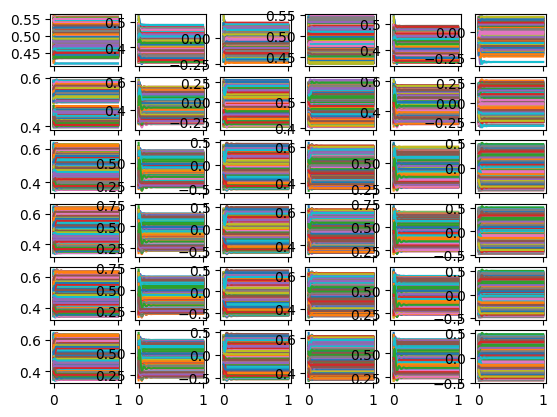

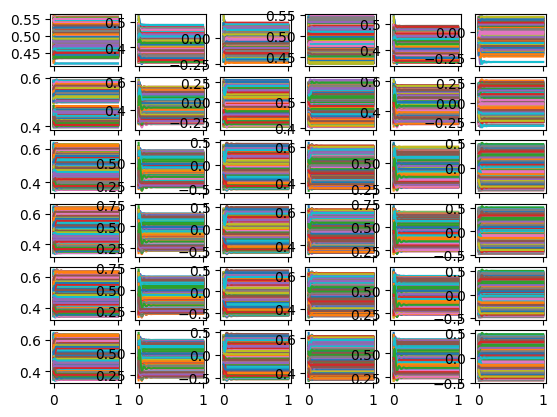

In [51]:
fd_smooth.plot()

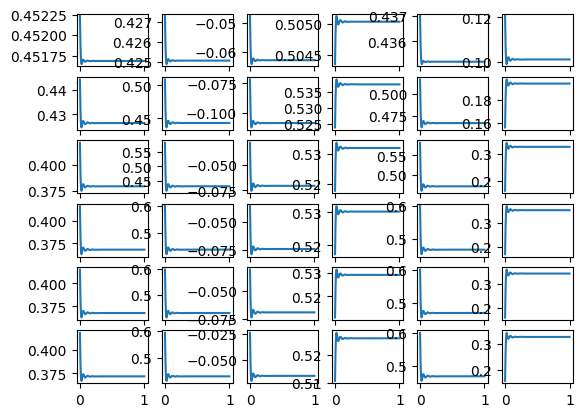

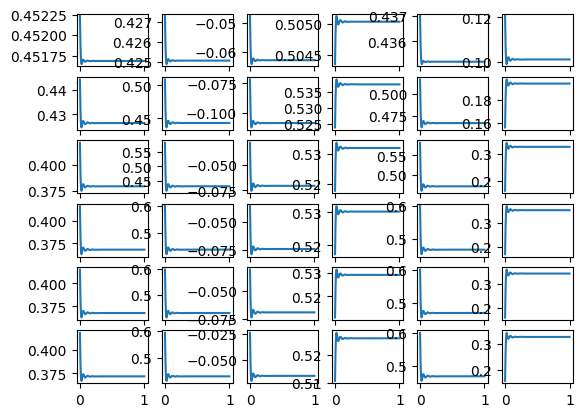

In [50]:
fd_smooth[0].plot()

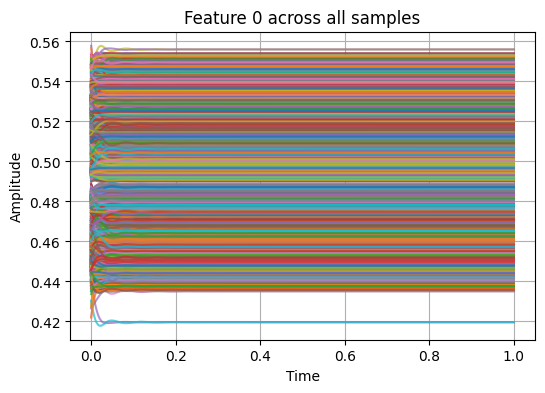

In [49]:
import matplotlib.pyplot as plt

feature_index = 0  # Ï≤´ Î≤àÏß∏ feature
x = fd_smooth.grid_points[0]  # Í≥µÌÜµ grid
n_samples = fd_smooth.data_matrix.shape[0]

plt.figure(figsize=(6, 4))
for i in range(n_samples):
    y = fd_smooth.data_matrix[i, :, feature_index]
    plt.plot(x, y, alpha=0.7)

plt.title(f"Feature {feature_index} across all samples")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
# 1) ÏÑ∏Í∑∏Î®ºÌä∏ Î°úÎìú
segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
x_data, y_data = load_segmented_time_series(segment_dir, max_len=11)

# FDataGridÎ°ú Î≥ÄÌôò
x_data = np.array(x_data)
x_data = np.transpose(x_data, (0, 2, 1))  # (samples, features, timesteps)

In [ ]:
print("x_data shape:", x_data.shape)
print("Example entry shape:", x_data[0].shape)

x_data shape: (5296, 300, 36)
Example entry shape: (300, 36)


In [2]:
print(x_data.shape[2])

NameError: name 'x_data' is not defined

In [49]:
test_dir = "/Users/junokim/Desktop/jupyteryong2/slr/test"
predictions = []

for file_name in os.listdir(test_dir):
    if file_name.endswith('.csv'):
        df = pd.read_csv(os.path.join(test_dir, file_name))
        time_series = df.iloc[:, 3:].values
        time_series = pad_with_last_row(time_series, fixed_rows=11)
        fd = FDataGrid(data_matrix=time_series.T, grid_points=np.linspace(0, 1, 11))
        basis = BSplineBasis(n_basis=7)
        smoother = BasisSmoother(basis=basis)
        fd = smoother.fit_transform(fd)
        pred = model.predict([fd])[0]
        predictions.append((file_name, pred))

label_meaning = {
    '377': 'Ïò¨Î∞îÎ•∏ ÏÇ¨Ïù¥Îìú Î†àÌÑ∞Îü¥ Î†àÏù¥Ï¶à ÏûêÏÑ∏',
    '378': 'Î¨¥Î¶é Î∞òÎèôÏù¥ ÏûàÎäî ÏûêÏÑ∏',
    '379': 'Ïñ¥Íπ® ÏúºÏì±ÌïòÎäî ÏûêÏÑ∏',
    '380': 'ÏÉÅÏôÑ/Ï†ÑÏôÑ Í∞ÅÎèÑ Í≥†Ï†ï ÏïàÎêú ÏûêÏÑ∏',
    '381': 'ÏÜêÎ™© Í∞ÅÎèÑ Í≥†Ï†ï ÏïàÎêú ÏûêÏÑ∏',
    '382': 'ÏÉÅÏ≤¥ Î∞òÎèôÏù¥ ÏûàÎäî ÏûêÏÑ∏'
}

for fname, label in predictions:
    print(f"{fname} ‚Üí {label} ({label_meaning.get(label, 'Ïïå Ïàò ÏóÜÏùå')})")

In [ ]:
import numpy as np
from skfda import FDataGrid
from sklearn.decomposition import PCA

def mfpca_via_univariate(fd: FDataGrid,
                         n_components_global: int,
                         n_components_univariate: int):
    """
    Í∞ÑÎã® MFPCA Íµ¨ÌòÑ: Í∞Å Ï∞®ÏõêÎ≥ÑÎ°ú FPCA ‚Üí Ïä§ÏΩîÏñ¥ Î≥ëÌï© ‚Üí PCA
    
    Parameters
    ----------
    fd : FDataGrid
        data_matrix shape = (n_samples, n_timepoints, n_features)
    n_components_global : int
        ÏµúÏ¢Ö PCA ÏÑ±Î∂Ñ Í∞úÏàò (MFPCA Ï∂ï Í∞úÏàò)
    n_components_univariate : int
        Í∞Å Ï∞®ÏõêÎ≥Ñ FPCAÏóêÏÑú ÎΩëÏùÑ ÏÑ±Î∂Ñ Í∞úÏàò
        
    Returns
    -------
    fps : list of FPCA
        Í∞Å ÌîºÏ≤òÎ≥Ñ FPCA Í∞ùÏ≤¥
    pca : PCA
        Ïä§ÏΩîÏñ¥ Î≥ëÌï© ÌõÑ Ï†ÅÏö©Îêú Ï†ÑÏó≠ PCA Í∞ùÏ≤¥
    global_scores : ndarray, shape (n_samples, n_components_global)
        ÏµúÏ¢Ö MFPCA Ï†êÏàò
    """
    # 1) Univariate FPCA for each feature
    n_samples, n_timepoints, n_features = fd.data_matrix.shape
    grids = fd.grid_points[0]  # length = n_timepoints

    fps = []
    scores_list = []
    for j in range(n_features):
        # jÎ≤àÏß∏ featureÎßå Í≥®Îùº FDataGrid ÏÉùÏÑ±
        data_j = fd.data_matrix[:, :, j]           # (n_samples, n_timepoints)
        fd_j   = FDataGrid(data_matrix=data_j,     # FDataGrid expects shape (samples, timepoints)
                           grid_points=[grids])
        fpca_j = FPCA(n_components=n_components_univariate)
        fpca_j.fit(fd_j)
        scores_j = fpca_j.transform(fd_j)         # (n_samples, n_components_univariate)
        
        fps.append(fpca_j)
        scores_list.append(scores_j)
    
    # 2) Ïä§ÏΩîÏñ¥ Î≥ëÌï©
    # shape ‚Üí (n_samples, n_features * n_components_univariate)
    S = np.hstack(scores_list)
    
    # 3) Global PCA (MFPCA)
    pca = PCA(n_components=n_components_global)
    global_scores = pca.fit_transform(S)
    
    return fps, pca, global_scores

In [ ]:
class FtsClassifier:
    def __init__(self, n_components=5):
        self.classifiers_mapping = {}
        self.n_components = n_components

    def fit(self, fd_train, y_train):
        fpca = FPCA(n_components=self.n_components)
        fpca.fit(fd_train)
        scores = fpca.transform(fd_train)
        clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        clf.fit(scores, y_train)
        self.classifiers_mapping['fpca'] = fpca
        self.classifiers_mapping['classifier'] = clf

    def predict(self, fd_list):
        fpca = self.classifiers_mapping['fpca']
        clf = self.classifiers_mapping['classifier']
        scores = fpca.transform(fd_list)
        return clf.predict(scores)

    def evaluate(self, fd_test, y_test):
        y_pred = self.predict(fd_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"üìä Accuracy: {acc:.4f}")
        print("üßÆ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("üìù Classification Report:\n", classification_report(y_test, y_pred))
        return acc

In [ ]:
from fts_data_utils import load_segmented_time_series, pad_with_last_row
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import BSplineBasis
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1) Îç∞Ïù¥ÌÑ∞ Î°úÎìú
x_data, y_data = load_segmented_time_series("/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2", max_len=11)
# x_data.shape = (n_samples, 11, n_features)

# 2) Ìï®ÏàòÌòï Í∞ùÏ≤¥Î°ú Î≥ÄÌôò + Ïä§Î¨¥Îî©
grid = np.linspace(0, 1, 11)
fd_all = FDataGrid(data_matrix=x_data, grid_points=[grid])
smoother = BasisSmoother(basis=BSplineBasis(n_basis=30))
fd_all = smoother.fit_transform(fd_all)

# 3) train/test split
idx = np.arange(len(y_data))
tr, te, y_tr, y_te = train_test_split(idx, y_data, test_size=0.2, stratify=y_data)
fd_tr, fd_te = fd_all[tr], fd_all[te]

# 4) MFPCA via univariate
fps, pca, X_tr = mfpca_via_univariate(fd_tr,
                                      n_components_global=300,
                                      n_components_univariate=10)
X_te = pca.transform(np.hstack([
    fps[j].transform(FDataGrid(fd_te.data_matrix[:,:,j], [grid]))
    for j in range(fd_te.data_matrix.shape[2])
]))

# 5) Î∂ÑÎ•òÍ∏∞ ÌïôÏäµ/ÌèâÍ∞Ä
clf = RidgeClassifierCV(alphas=np.logspace(-3,3,10))
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
print("Accuracy:", accuracy_score(y_te, y_pred))

Accuracy: 0.2009433962264151


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# ‚Ä¶ (Ïïû Î∂ÄÎ∂ÑÏùÄ Í∑∏ÎåÄÎ°ú) ‚Ä¶

# 4) MFPCA via univariate
fps, pca, X_tr = mfpca_via_univariate(
    fd_tr,
    n_components_global=300,
    n_components_univariate=10
)
X_te = pca.transform(np.hstack([
    fps[j].transform(
        FDataGrid(fd_te.data_matrix[:, :, j], [grid])
    )
    for j in range(fd_te.data_matrix.shape[2])
]))

# 5) Grid Search + SVM Î∂ÑÎ•òÍ∏∞ ÌïôÏäµ/ÌèâÍ∞Ä
# --------------------------------------
# ÌååÏù¥ÌîÑÎùºÏù∏ Ï†ïÏùò
pipeline = Pipeline([
    ("scaler", StandardScaler()),            # Ïä§ÏΩîÏñ¥ Ï†ïÍ∑úÌôî
    ("svc",    SVC(kernel="rbf", class_weight="balanced"))
])

# ÌÉêÏÉâÌï† ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ Í∑∏Î¶¨Îìú
param_grid = {
    "svc__C":     [0.1, 1, 10],
    "svc__gamma": ["scale", 0.01, 0.1],
}

# 5Í≤π ÍµêÏ∞®Í≤ÄÏ¶ù GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=1,        # Î©ÄÌã∞ÏΩîÏñ¥ Î≥ëÎ†¨Ìôî
    verbose=1
)

# ÌïôÏäµ
grid.fit(X_tr, y_tr)

# ÏµúÍ≥† ÌååÎùºÎØ∏ÌÑ∞ÏôÄ CV Ï†êÏàò Ï∂úÎ†•
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÏÑ±Îä•
test_acc = grid.score(X_te, y_te)
print("Test accuracy:", test_acc)

AssertionError: 

In [16]:
from skfda import FDataGrid
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
import numpy as np

segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# 1) Îç∞Ïù¥ÌÑ∞ Î°úÎìú + Ìå®Îî©
x_data, y_data = load_segmented_time_series(segment_dir, max_len=100)

# x_data.shape = (n_samples, timepoints, n_features)
grid = np.linspace(0, 1, 100)

# 1-1) FDataGrid ÏÉùÏÑ±
fd = FDataGrid(data_matrix=x_data, grid_points=[grid])

# 1-2) (ÏÑ†ÌÉù) B-spline Ïä§Î¨¥Îî©
basis    = BSplineBasis(n_basis=9)
smoother = BasisSmoother(basis=basis)
fd_smooth = smoother.fit_transform(fd)

from skfda.preprocessing.dim_reduction import FPCA
from sklearn.decomposition import PCA

def mfpca_via_univariate(fd, n_univ=5, n_global=20):
    # fd.data_matrix.shape == (n_samples, timepoints, n_features)
    n_features = fd.data_matrix.shape[2]
    grids      = fd.grid_points[0]

    # 2-1) Í∞Å ÌîºÏ≤òÎ≥Ñ FPCA ‚Üí Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
    fps = []
    scores = []
    for j in range(n_features):
        # jÎ≤àÏß∏ Ï±ÑÎÑêÎßå ÎΩëÏïÑ FDataGrid Í∞ùÏ≤¥ ÏÉùÏÑ±
        fd_j = FDataGrid(data_matrix=fd.data_matrix[:, :, j],
                         grid_points=[grids])
        fpca_j = FPCA(n_components=n_univ)
        fpca_j.fit(fd_j)
        S_j = fpca_j.transform(fd_j)             # (n_samples, n_univ)
        fps.append(fpca_j)
        scores.append(S_j)

    # 2-2) Ïä§ÏΩîÏñ¥ Ìï©ÏπòÍ∏∞ ‚Üí (n_samples, n_features*n_univ)
    import numpy as np
    S = np.hstack(scores)

    # 2-3) Global PCA ‚Üí (n_samples, n_global)
    pca = PCA(n_components=n_global)
    G = pca.fit_transform(S)

    return fps, pca, G

# Ïã§Ìñâ ÏòàÏãú
fps, pca, X = mfpca_via_univariate(fd_smooth,
                                   n_univ=8,
                                   n_global=30)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score

# 3-1) train/test split
idx = np.arange(len(y_data))
tr, te, y_tr, y_te = train_test_split(idx, y_data, test_size=0.2,
                                      stratify=y_data, random_state=42)
X_tr, X_te = X[tr], X[te]

# 3-2) RidgeClassifierCV (ÎòêÎäî ÏõêÌïòÎäî Î∂ÑÎ•òÍ∏∞)
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_tr, y_tr)

# 3-3) ÌèâÍ∞Ä
y_pred = clf.predict(X_te)
print("Accuracy:", accuracy_score(y_te, y_pred))

Accuracy: 0.14433962264150943


In [8]:
# 1) ÏÑ∏Í∑∏Î®ºÌä∏ Î°úÎìú: multivariate (Î™®Îì† Í¥ÄÏ†à xyz)
segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# load_segmented_time_series: Í∞ÅÍ∞Å (timepoints, features) ÌòïÌÉúÎ°ú Î∞òÌôò
x_data, y_data = load_segmented_time_series(segment_dir, max_len=11)

# x_data.shape == (n_samples, 11, n_features)
# 2) FDataGrid ÏÉùÏÑ± (multivariate codomain)
grid = np.linspace(0, 1, 11)              # ÏãúÍ∞Ñ Ï†ïÍ∑úÌôî
fd = FDataGrid(data_matrix=x_data,       # (n_samples, timepoints, features)
               grid_points=[grid])       # Îã®Ïùº ÎèÑÎ©îÏù∏

# 3) Ïä§Î¨¥Îî© (ÏòµÏÖò)
basis    = BSplineBasis(n_basis=9)
smoother = BasisSmoother(basis=basis)
fd_smooth = smoother.fit_transform(fd)

# 4) ÌïôÏäµ/ÌÖåÏä§Ìä∏ Î∂ÑÎ¶¨
idx = np.arange(len(y_data))
train_idx, test_idx, y_train, y_test = train_test_split(
    idx, y_data, test_size=0.2, stratify=y_data, random_state=42
)
fd_train = fd_smooth[train_idx]
fd_test  = fd_smooth[test_idx]

# 5) MFPCA + RidgeClassifier ÌïôÏäµ
n_components = 15
mfpca = MFPCA(n_components=n_components)
mfpca.fit(fd_train)

# Í∞Å sampleÏùÑ Ï£ºÏÑ±Î∂Ñ Ï†êÏàò(feature)Î°ú Î≥ÄÌôò
X_train_scores = mfpca.transform(fd_train)
X_test_scores  = mfpca.transform(fd_test)

# Î∂ÑÎ•òÍ∏∞ ÌïôÏäµ
clf = RidgeClassifierCV(alphas=np.logspace(-3,3,10))
clf.fit(X_train_scores, y_train)

# 6) ÌèâÍ∞Ä
y_pred = clf.predict(X_test_scores)
print("‚ñ∂ Test Accuracy:", accuracy_score(y_test, y_pred))
print("‚ñ∂ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("‚ñ∂ Classification Report:\n", classification_report(y_test, y_pred))

# 7) Ï†ÄÏû•
model = {"mfpca": mfpca, "classifier": clf}
with open("lateralraise_mfpca.pkl", "wb") as f:
    pickle.dump(model, f)

AttributeError: 'FDataGrid' object has no attribute 'data'